In [ ]:
import os
import math
import random
import cv2

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


drive/MyDrive/Project/All_picture/00000101_0.jpg
drive/MyDrive/Project/All_xml/00000101_0.xml
67.0 323.0 569.0 630.0


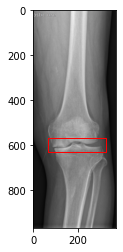

In [ ]:
from glob import glob
from google.colab.patches import cv2_imshow
import cv2
import xml.etree.ElementTree as et   
from matplotlib.patches import Rectangle 

image_dir = 'drive/MyDrive/Project/All_picture/'
bbox_dir = 'drive/MyDrive/Project/All_xml/'

image_files = sorted(glob(image_dir + '*.jpg'))
bbox_files = sorted(glob(bbox_dir + "*.xml"))

test = 100

image_path = image_files[test] 
bbox_path = bbox_files[test]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(image_path)
print(bbox_path)
tree = et.parse(bbox_path)

xmin = float(tree.find('./object/bndbox/xmin').text)
xmax = float(tree.find('./object/bndbox/xmax').text)
ymin = float(tree.find('./object/bndbox/ymin').text)
ymax = float(tree.find('./object/bndbox/ymax').text)

print(xmin, xmax, ymin, ymax)

rect_x = xmin
rect_y = ymin
rect_w = xmax - xmin
rect_h = ymax - ymin

rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
plt.axes().add_patch(rect)
plt.imshow(image)
plt.show()

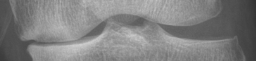

In [ ]:
src = cv2.imread(image_path)
dst = src[569:630, 67:323].copy()
# => [ymin:ymax, xmin:xmax]
cv2_imshow(dst)
cv2.waitKey()
cv2.destroyAllWindows()

In [ ]:
print(len(image_files))
print(len(bbox_files))

8261
8261


In [ ]:
csv_path = 'drive/MyDrive/Project/CSV/KL_grade_kfold_FINAL.csv'
df = pd.read_csv(csv_path)
df = df[['File_name_pic', 'real_xml', 'KL_Grade', 'fold']]
df

,File_name_pic,real_xml,KL_Grade,fold
0,00000104_1.jpg,00000104_1.xml,0,5
1,00000104_2.jpg,00000104_2.xml,0,1
2,00000204_1.jpg,00000204_1.xml,0,5
3,00000204_2.jpg,00000204_2.xml,0,3
4,00000304_1.jpg,00000304_1.xml,2,5
...,...,...,...,...
8256,00000296_0.jpg,00000296_0.xml,4,2
8257,00000297_0.jpg,00000297_0.xml,4,4
8258,00000298_0.jpg,00000298_0.xml,4,2
8259,00000299_0.jpg,00000299_0.xml,4,2


In [ ]:
df['KL_Grade'].value_counts().sort_index()

0    2507
1    1578
2    2352
3    1231
4     593
Name: KL_Grade, dtype: int64

In [ ]:
import pandas as pd
import numpy as np
import cv2
from glob import glob
import xml.etree.ElementTree as et
from tensorflow import keras
from matplotlib.patches import Rectangle

csv_path = 'drive/MyDrive/Project/CSV/KL_grade_kfold_FINAL.csv'
df = pd.read_csv(csv_path)
idx = random.choice(range(len(df)))

class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path,
                 fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.fold = fold
        self.image_size = image_size
        self.mode = mode
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
            
        self.on_epoch_end()

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
        
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
    
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
        
    
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['File_name_pic']
            bbox_name = file_name.replace('.jpg', '.xml')

            image = cv2.imread(f'drive/MyDrive/Project/All_picture/{file_name}')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # 이미지 빨간박스 그린곳 만큼 자르기 
            tree = et.parse(f'drive/MyDrive/Project/All_xml/{bbox_name}')

            xmin = float(tree.find('./object/bndbox/xmin').text)
            xmax = float(tree.find('./object/bndbox/xmax').text)
            ymin = float(tree.find('./object/bndbox/ymin').text)
            ymax = float(tree.find('./object/bndbox/ymax').text)

            image = image[int(ymin):int(ymax), int(xmin):int(xmax)].copy()
            # ---------------------------------------
            image = cv2.resize(image, (self.image_size, self.image_size))      
            image = image / 255.
            
            label = int(r['KL_Grade'])
            
            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y


In [ ]:
csv_path = 'drive/MyDrive/Project/CSV/KL_grade_kfold_FINAL.csv'

# __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True)
train_generator = DataGenerator(
    batch_size = 50,
    csv_path = csv_path,
    fold = 2,
    image_size = 256,
    mode = 'train',
    shuffle = True
)

valid_generator = DataGenerator(
    batch_size = 50,
    csv_path = csv_path,
    fold = 2,
    image_size = 256,
    mode = 'val',
    shuffle = True
)

In [ ]:
print(len(train_generator))
print(len(valid_generator))

133
34


In [ ]:
(735 + 184) * 9

8271

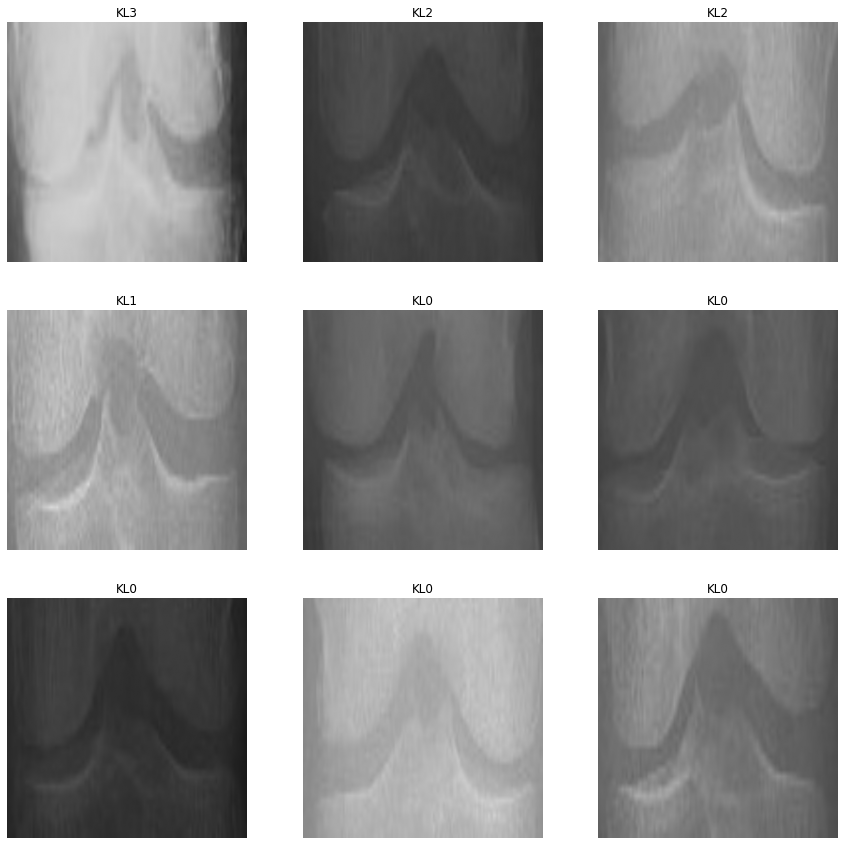

In [ ]:
KL_name = ['KL0', 'KL1', 'KL2', 'KL3', 'KL4']

for batch in train_generator:
    X, y = batch
    plt.figure(figsize=(15, 15))
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(X[i])
        plt.title(KL_name[y[i]])
        plt.axis('off')
    break

In [ ]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras import layers

def get_sequential_model(input_shape):
    model = keras.Sequential(
        [
            # input
            layers.Input(input_shape),
            
            # 1st 
            # 64개의 필터 / 3x3 사이즈 필터 크기 / strides : (위로 1, 아래로 1씩 움직인다.) / padding = same 기존의 크기와 동일하게 만들어준다. /
            layers.Conv2D(32, 3, strides=1, activation='relu', padding='same', name ='Conv_layer1-1'),
            layers.Conv2D(32, 3, strides=1, activation='relu', padding='same', name ='Conv_layer1-2'),
            layers.MaxPool2D(name='Pooling_1'),
            layers.BatchNormalization(name = 'Batch_Norm_1'),
            layers.Dropout(0.2),
            
            # 2nd
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same', name ='Conv_layer2-1'),
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same', name ='Conv_layer2-2'),
            layers.MaxPool2D(name='Pooling_2'),
            layers.BatchNormalization(name = 'Batch_Norm_2'),
            layers.Dropout(0.2),
            
            #3 rd
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same', name ='Conv_layer3-1'),
            layers.MaxPool2D(name='Pooling_3'),
            layers.BatchNormalization(name = 'Batch_Norm_3'),
            layers.Dropout(0.2),
            
            # 4th
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same', name ='Conv_layer4-1'),
            layers.MaxPool2D(name='Pooling_4'),
            layers.BatchNormalization(name = 'Batch_Norm_4'),
            layers.Dropout(0.2),
            
            # 5th
            layers.Conv2D(256, 3, strides=1, activation='relu', padding='same', name ='Conv_layer5-1'),
            layers.MaxPool2D(name='Pooling_5'),
            layers.BatchNormalization(name = 'Batch_Norm_5'),
            layers.Dropout(0.2),
            
            # Classifier
            
            # layers.Flatten(input_shape= input_shape),            
            layers.GlobalMaxPool2D(),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(5, activation='softmax')
        ]
    )
    
    return model

input_shape = (256, 256, 3)
model = get_sequential_model(input_shape)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
	# metrics=['sparse_categorical_accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_layer1-1 (Conv2D)      (None, 256, 256, 32)      896       
                                                                 
 Conv_layer1-2 (Conv2D)      (None, 256, 256, 32)      9248      
                                                                 
 Pooling_1 (MaxPooling2D)    (None, 128, 128, 32)      0         
                                                                 
 Batch_Norm_1 (BatchNormaliz  (None, 128, 128, 32)     128       
 ation)                                                          
                                                                 
 dropout_7 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 Conv_layer2-1 (Conv2D)      (None, 128, 128, 64)      18496     
                                                      

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
filepath="/content/drive/MyDrive/Project/Checkpoint/weights-improvment-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', patience=3, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

log_csv = CSVLogger('my_logs.csv', separator=',', append=False)

callbacks_list = [checkpoint, early_stop, log_csv]

In [ ]:
history = model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=callbacks_list)

model.save('kl_grade.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.6432 - acc: 0.2960 
Epoch 1: saving model to /content/drive/MyDrive/Project/weights-improvment-01-0.30.hdf5
133/133 [==============================] - 8428s 63s/step - loss: 1.6432 - acc: 0.2960 - val_loss: 1.6214 - val_acc: 0.3039
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 1.5095 - acc: 0.3053
Epoch 2: saving model to /content/drive/MyDrive/Project/weights-improvment-02-0.30.hdf5
133/133 [==============================] - 799s 6s/step - loss: 1.5095 - acc: 0.3053 - val_loss: 1.7336 - val_acc: 0.3039
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 1.4762 - acc: 0.3288
Epoch 3: saving model to /content/drive/MyDrive/Project/weights-improvment-03-0.31.hdf5
133/133 [==============================] - 806s 6s/step - loss: 1.4762 - acc: 0.3288 - val_loss: 1.5200 - val_acc: 0.3099
Epoch 4/20
 17/133 [==>...........................] - ETA: 11:11 - loss: 1.4586 - acc: 0.3071

In [ ]:
import matplotlib.pyplot as plt
history = history.history
plt.figure(figsize=(15, 5))
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")
plt.show()

In [ ]:
for images, masks in valid_generator:
    break
preds = model.predict(images)

In [ ]:
import random
idx = random.choice(range(len(preds)))
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(images[idx, ...])
plt.subplot(1, 3, 2)
plt.imshow(masks[idx])
plt.subplot(1, 3, 3)
pred = np.argmax(preds[idx], axis=-1)
plt.imshow(pred)